<a href="https://colab.research.google.com/github/drahulnayak/Breast-cancer-detection-using-CNN---Deep-Learning-/blob/main/Note.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install deap gdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 1.2 MB/s eta 0:00:00


In [ ]:
!gdown 1ppMGBDeBD0hJbd3XhtrMuUGT-9WSfGjd

Downloading...
From (original): https://drive.google.com/uc?id=1ppMGBDeBD0hJbd3XhtrMuUGT-9WSfGjd
From (redirected): https://drive.google.com/uc?id=1ppMGBDeBD0hJbd3XhtrMuUGT-9WSfGjd&confirm=t&uuid=121e6f7b-893e-4558-a177-d1ab97c480bc
To: /content/MAT_Files.zip
100% 146M/146M [00:07<00:00, 18.5MB/s]


In [ ]:
!unzip /content/MAT_Files.zip

Archive:  /content/MAT_Files.zip
  inflating: MAT files/S1000001_BandRejection.mat  
  inflating: MAT files/Subject10-Guilty-Trial-10_BandRejection.mat  
  inflating: MAT files/Subject10-Guilty-Trial-16_BandRejection.mat  
  inflating: MAT files/Subject10-Guilty-Trial-20_BandRejection.mat  
  inflating: MAT files/Subject10-Innocent-Trial-1_BandRejection.mat  
  inflating: MAT files/Subject10-Innocent-Trial-17_BandRejection.mat  
  inflating: MAT files/Subject10-Innocent-Trial-19_BandRejection.mat  
  inflating: MAT files/Subject10-Innocent-Trial-2_BandRejection.mat  
  inflating: MAT files/Subject10-Innocent-Trial-22_BandRejection.mat  
  inflating: MAT files/Subject10-Innocent-Trial-24_BandRejection.mat  
  inflating: MAT files/Subject10-Innocent-Trial-26_BandRejection.mat  
  inflating: MAT files/Subject10-Innocent-Trial-27_BandRejection.mat  
  inflating: MAT files/Subject10-Innocent-Trial-28_BandRejection.mat  
  inflating: MAT files/Subject10-Innocent-Trial-29_BandRejection.mat  


In [ ]:
import numpy as np
import scipy.io
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from deap import base, creator, tools, algorithms
import random

In [ ]:
import os
import torch
from scipy.io import loadmat
import numpy as np
import re

mat_files_directory = '/content/MAT files'

relevant_channels = ['Fz', 'FC1', 'FC2', 'C3', 'Cz', 'C4', 'CP5', 'CP1', 'CP2', 'CP6', 'P3', 'Pz', 'P4', 'O1', 'Oz', 'O2']

tensors = []
labels = []

for file_name in os.listdir(mat_files_directory):
    if file_name.endswith('.mat'):
        mat_file_path = os.path.join(mat_files_directory, file_name)
        data = loadmat(mat_file_path)

        # Extract labels from the file name
        # Example: "Subject-1InnocTrial-11_BandRejection.mat" or "Subject2-InnocentTrial_20.mat"
        # Extracting Trial type (e.g., Innocent, Guilty)
        if 'innoc' in file_name.lower():
            label = 'Innocent'
        elif 'guilty' in file_name.lower():
            label = 'Guilty'
        else:
            print(file_name)
            label = 'Unknown'
            continue

        channel_data = [data[channel] for channel in relevant_channels if channel in data]

        min_length = min([ch_data.shape[1] for ch_data in channel_data])
        channel_data = [ch_data[:, :min_length] for ch_data in channel_data]

        data_array = np.stack(channel_data, axis=0)

        tensor_data = torch.tensor(data_array, dtype=torch.float32)

        tensors.append(tensor_data)
        labels.append(label)

# Determine the maximum size for each dimension
max_shape = tuple(max(sizes) for sizes in zip(*[t.size() for t in tensors]))

# Pad each tensor to the maximum size
padded_tensors = []
for t in tensors:
    pad_size = [(0, max_dim - cur_dim) for cur_dim, max_dim in zip(t.size(), max_shape)]
    pad_size = [item for sublist in pad_size for item in sublist][::-1]  # Flatten and reverse
    padded_tensors.append(torch.nn.functional.pad(t, pad_size))

# Stack the padded tensors
stacked_tensor = torch.stack(padded_tensors)

print(stacked_tensor.shape)
print(len(labels))

S1000001_BandRejection.mat
torch.Size([249, 16, 9779, 1])
249


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
print("Classes:", label_encoder.classes_)


Classes: ['Guilty' 'Innocent']


In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
data = stacked_tensor

flattened_data = data.view(data.size(0), -1).numpy()  # Shape: [249, 16 * 9779]


# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(flattened_data)

# Apply K-Means clustering to divide the data into 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Splitting the data into three batches based on clusters
batches = {i: [] for i in range(3)}
for i, cluster in enumerate(clusters):
    batches[cluster].append(i)

# Create datasets for each cluster
datasets = []
for batch_indices in batches.values():
    X_batch = X_scaled[batch_indices]
    y_batch = labels_encoded[batch_indices]
    datasets.append((X_batch, y_batch))

# Display the size of each batch
for i, (X_batch, y_batch) in enumerate(datasets):
    print(f"Batch {i+1} size: {X_batch.shape}")


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Batch 1 size: (27, 156464)
Batch 2 size: (29, 156464)
Batch 3 size: (193, 156464)


In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Define the base models
base_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Support Vector Classifier': SVC(probability=True),
    'Decision Tree': DecisionTreeClassifier()
}

bagging_models = []
bag_size = 0.8  # Use 80% of the data for each bag

for i, (X_batch, y_batch) in enumerate(datasets):
    for name, base_model in base_models.items():
        for j in range(5):  # Train 5 bags for each model
            bagging_model = BaggingClassifier(base_model, n_estimators=1, max_samples=bag_size, random_state=j)
            bagging_model.fit(X_batch, y_batch)
            bagging_models.append((f"Batch_{i+1}_{name}_bag_{j}", bagging_model))


In [ ]:
from sklearn.metrics import accuracy_score

# Combine all batches for testing purposes
X_test_combined = np.vstack([X_batch for X_batch, _ in datasets])
y_test_combined = np.hstack([y_batch for _, y_batch in datasets])

# Evaluate all bagging models and store their accuracies
model_accuracies = []

for name, model in bagging_models:
    predictions = model.predict(X_test_combined)
    accuracy = accuracy_score(y_test_combined, predictions)
    model_accuracies.append((name, model, accuracy))

# Sort models based on accuracy and select the top 7
model_accuracies.sort(key=lambda x: x[2], reverse=True)
top_models = model_accuracies[:7]

# Display the top 7 models
for name, model, accuracy in top_models:
    print(f"{name} Accuracy: {accuracy:.4f}")


Batch_3_Logistic Regression_bag_1 Accuracy: 0.7510
Batch_3_Decision Tree_bag_1 Accuracy: 0.7510
Batch_3_Logistic Regression_bag_4 Accuracy: 0.7349
Batch_3_Decision Tree_bag_4 Accuracy: 0.7349
Batch_3_Logistic Regression_bag_0 Accuracy: 0.7269
Batch_3_Logistic Regression_bag_3 Accuracy: 0.7229
Batch_3_Decision Tree_bag_2 Accuracy: 0.7189


In [ ]:
# Layer 1: Use 3 models to classify the data
layer1_models = top_models[:3]

# First Layer Predictions
layer1_preds = [model.predict_proba(X_test_combined)[:, 1] for _, model, _ in layer1_models]

# Combine predictions from Layer 1
layer1_combined_preds = np.mean(layer1_preds, axis=0)
layer1_guilty_indices = np.where(layer1_combined_preds > 0.5)[0]

# Data classified as "Guilty"
X_layer2 = X_test_combined[layer1_guilty_indices]
y_layer2 = y_test_combined[layer1_guilty_indices]

# Layer 2: Use 2 more models
layer2_models = top_models[3:5]

# Second Layer Predictions
layer2_preds = [model.predict_proba(X_layer2)[:, 1] for _, model, _ in layer2_models]

# Combine predictions from Layer 2
layer2_combined_preds = np.mean(layer2_preds, axis=0)
layer2_guilty_indices = np.where(layer2_combined_preds > 0.5)[0]

# Data classified as "Guilty" from Layer 2
X_layer3 = X_layer2[layer2_guilty_indices]
y_layer3 = y_layer2[layer2_guilty_indices]

# Layer 3: Use the final 2 models
layer3_models = top_models[5:7]

# Third Layer Predictions
layer3_preds = [model.predict_proba(X_layer3)[:, 1] for _, model, _ in layer3_models]

# Combine predictions from Layer 3
layer3_combined_preds = np.mean(layer3_preds, axis=0)
layer3_guilty_indices = np.where(layer3_combined_preds > 0.5)[0]

# Final predictions for Layer 3
final_predictions = np.zeros_like(y_test_combined)
final_predictions[layer1_guilty_indices[layer2_guilty_indices[layer3_guilty_indices]]] = 1

# Final Accuracy Calculation
final_accuracy = accuracy_score(y_test_combined, final_predictions)
print(f"Final Layered Classification Accuracy: {final_accuracy:.4f}")


Final Layered Classification Accuracy: 0.7189


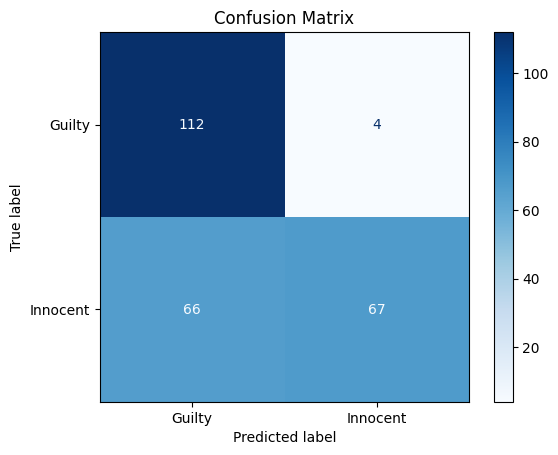

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test_combined, final_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()